In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the ASL dataset

In [6]:
train_df = pd.read_csv("/content/sign_mnist_test.csv")
test_df = pd.read_csv("/content/sign_mnist_train.csv")

In [7]:
test = pd.read_csv("/content/sign_mnist_test.csv")
y = test['label']

**The dataset seems balanced as for each training label , enough training examples exist**

In [8]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [10]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [11]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [12]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

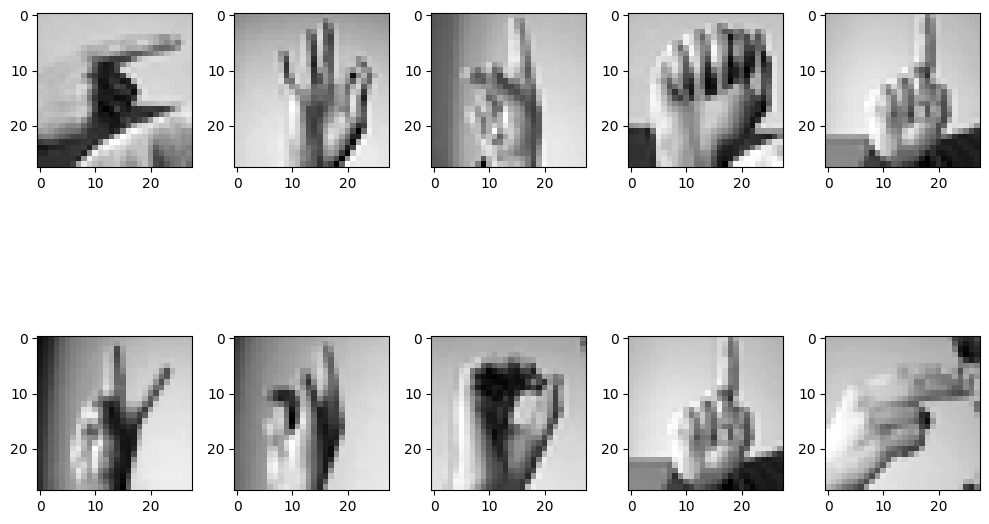

In [13]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [14]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE
**A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.**

* **A convolution does this by multiplying two matrices and yielding a third, smaller matrix.**
* **The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.**
* **In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure**
![image.png](attachment:image.png)

# Training The Model

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [16]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

In [41]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 4 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/4
57/57 [==============================] - 39s 682ms/step - loss: 0.0934 - accuracy: 0.9732 - val_loss: 0.4752 - val_accuracy: 0.8525 - lr: 2.5000e-04
Epoch 2/4
57/57 [==============================] - 38s 665ms/step - loss: 0.0848 - accuracy: 0.9756 - val_loss: 0.4499 - val_accuracy: 0.8565 - lr: 2.5000e-04
Epoch 3/4
57/57 [==============================] - 30s 523ms/step - loss: 0.0848 - accuracy: 0.9750 - val_loss: 0.3688 - val_accuracy: 0.8804 - lr: 2.5000e-04
Epoch 4/4
57/57 [==============================] - 29s 521ms/step - loss: 0.0703 - accuracy: 0.9810 - val_loss: 0.4177 - val_accuracy: 0.8684 - lr: 2.5000e-04


In [18]:
def resize_and_grayscale(image_path, size=(28, 28)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, size)
    img_matrix = np.array(img_resized)

    return img_matrix

In [55]:
import copy
a = resize_and_grayscale("/content/A.jpg").reshape(-1, 28, 28, 1)
c = resize_and_grayscale("/content/C.jpg").reshape(-1, 28, 28, 1)
w = resize_and_grayscale("/content/W.jpg").reshape(-1, 28, 28, 1)


predict_x=model.predict(w / 255)
print(predict_x)
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)


1/1 [==============================] - 0s 44ms/step
[[2.15049344e-03 4.81961069e-05 1.62591779e-04 7.01574318e-05
  1.72798662e-03 1.00736804e-01 2.82959827e-05 3.03789619e-07
  1.85552961e-03 9.27301699e-06 6.31099625e-04 9.55313735e-05
  1.23421706e-01 2.05252109e-05 4.78993665e-04 1.36627989e-06
  5.35239586e-08 7.34018158e-07 3.81120108e-02 1.35940184e-06
  2.93775797e-02 6.55116498e-01 1.02324220e-05 4.59427126e-02]]
[21]


In [50]:
x_train[0]

array([[[0.58431373],
        [0.58431373],
        [0.58823529],
        [0.58823529],
        [0.58823529],
        [0.59215686],
        [0.59215686],
        [0.58823529],
        [0.59215686],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.6       ],
        [0.6       ],
        [0.59215686],
        [0.59607843],
        [0.59607843],
        [0.6       ],
        [0.59607843],
        [0.59607843],
        [0.59215686],
        [0.59215686],
        [0.58823529],
        [0.58823529],
        [0.58823529],
        [0.58431373]],

       [[0.58823529],
        [0.58823529],
        [0.58823529],
        [0.59607843],
        [0.59607843],
        [0.59215686],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.59607843],
        [0.6       ],
        [0.60392157],
        [0.6       ],
        [0.60392157],
        [0.60392157],
        [0.6       ],
        

In [51]:
a

array([[[[155],
         [154],
         [156],
         [159],
         [161],
         [165],
         [166],
         [169],
         [169],
         [173],
         [176],
         [181],
         [179],
         [181],
         [183],
         [181],
         [187],
         [188],
         [190],
         [190],
         [195],
         [195],
         [196],
         [194],
         [198],
         [197],
         [199],
         [199]],

        [[153],
         [158],
         [158],
         [159],
         [166],
         [168],
         [169],
         [172],
         [173],
         [175],
         [180],
         [180],
         [182],
         [184],
         [186],
         [188],
         [189],
         [192],
         [192],
         [194],
         [194],
         [195],
         [196],
         [196],
         [199],
         [199],
         [201],
         [199]],

        [[156],
         [159],
         [162],
         [164],
         [169],
         [169],
    